# Models (sepsis-pics)


## Common


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from common_eicu import KEY_IDENTITY, KEY_FLAG, CATEGORICAL_COLUMNS
from common_model_eicu import SEED, SCORING, cv, get_full_data, test_model


In [7]:
MODEL_RESULT_PATH = './data/model_result.csv'

# index: 'Accuracy Mean', 'Accuracy Std', 'AUC Mean', 'AUC Std'
df_result = pd.read_csv(
    MODEL_RESULT_PATH,
    index_col='Index',
)
print(
    df_result.T.sort_values(
        by=['Accuracy Mean', 'AUC Mean'],
        ascending=False,
    )
)

def update_result(name, *, accuracy_mean, accuracy_std, auc_mean, auc_std):
    df_result[name] = [accuracy_mean, accuracy_std, auc_mean, auc_std]


Index         Accuracy Mean  Accuracy Std  AUC Mean   AUC Std
CatBoost           0.995589      0.001132  0.996087  0.001225
LightGB            0.995162      0.001381  0.996054  0.001477
XGBoost            0.995096      0.001093  0.994320  0.001801
HistGB             0.994351      0.001502  0.995599  0.001646
AdaBoost           0.992974      0.001921  0.994684  0.001718
DecisionTree       0.989201      0.001961  0.948664  0.012928
MLP                0.981605      0.003656  0.974707  0.008280
SVM                0.973136      0.003063  0.957260  0.010657
Logistic           0.965586      0.006560  0.955503  0.011602
ExtraTrees         0.961474      0.006486  0.977230  0.006083
NaiveBayes         0.961474      0.006486  0.688748  0.033740
Ridge              0.961398      0.006522  0.952498  0.013035
LDA                0.960830      0.009653  0.952497  0.013035
KNN                0.950638      0.005488  0.543913  0.024953


In [8]:
def plot_roc_file(title, input_path, auc_mean, auc_std):

    df_roc = pd.read_csv(input_path, sep='\t')
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot()

    ax.set_title(title)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    t = [0, 1]
    ax.plot(t, t, '--', c='lightgray', label='chance level (AUC = 0.5)')

    x = df_roc['FPR']
    y = df_roc['TPR']
    label = fr'ROC (AUC = {auc_mean:.2f} $\pm$ {auc_std:.2f})'
    ax.plot(x, y, 'b-', label=label)

    ax.legend(loc='lower right')


In [9]:
def test_and_update(name, model, *, encode=False, n_jobs=None):
    '''
    Test the given model using sklearn's
    cross validation, print the result
    and pass it to `update_result`.

    Parameters
    ----------
    name : str
        Model name.
    model : scikit-learn compact model
        The model to test.
    encode : False, 'ordinal' or 'dummy', default=False
        Category encoding option.
        False - No encoding.
        'ordinal' - Use ordinal encoder.
        'dummy' - Use dummy encoder.
    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
    '''

    if encode == 'dummy':
        X = X_dummy
    elif encode == 'ordinal':
        X = X_ordinal
    else:
        X = X_raw

    result = test_model(
        model,
        X,
        y,
        groups,
        return_result=True,
        n_jobs=n_jobs,
    )

    update_result(
        name,
        accuracy_mean=result['accuracy_mean'],
        accuracy_std=result['accuracy_std'],
        auc_mean=result['auc_mean'],
        auc_std=result['auc_std'],
    )


## Prepare Data


In [10]:
df_data = get_full_data()


In [11]:
X_raw = df_data.drop(columns=[KEY_IDENTITY, KEY_FLAG])
X_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100308 entries, 0 to 100307
Data columns (total 57 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   gender              100308 non-null  category
 1   age                 100308 non-null  float64 
 2   ethnicity           100308 non-null  category
 3   Apache-IV           100308 non-null  float64 
 4   offset              100308 non-null  int64   
 5   vasopressor         100308 non-null  category
 6   heparin             100308 non-null  category
 7   urine               100308 non-null  float64 
 8   PEEP                100308 non-null  float64 
 9   creatinine          100308 non-null  float64 
 10  platelet            100308 non-null  float64 
 11  INR                 100308 non-null  float64 
 12  PT                  100308 non-null  float64 
 13  PTT                 100308 non-null  float64 
 14  lactate             100308 non-null  float64 
 15  RDW              

In [12]:
ordinal_encoder = OrdinalEncoder(
    dtype=np.uint8,
)
X_ordinal = X_raw.copy()
X_ordinal[CATEGORICAL_COLUMNS] = \
    ordinal_encoder.fit_transform(X_ordinal[CATEGORICAL_COLUMNS])
X_ordinal.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100308 entries, 0 to 100307
Data columns (total 57 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   gender              100308 non-null  uint8  
 1   age                 100308 non-null  float64
 2   ethnicity           100308 non-null  uint8  
 3   Apache-IV           100308 non-null  float64
 4   offset              100308 non-null  int64  
 5   vasopressor         100308 non-null  uint8  
 6   heparin             100308 non-null  uint8  
 7   urine               100308 non-null  float64
 8   PEEP                100308 non-null  float64
 9   creatinine          100308 non-null  float64
 10  platelet            100308 non-null  float64
 11  INR                 100308 non-null  float64
 12  PT                  100308 non-null  float64
 13  PTT                 100308 non-null  float64
 14  lactate             100308 non-null  float64
 15  RDW                 100308 non-nul

In [13]:
X_dummy = pd.get_dummies(X_raw)
X_dummy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100308 entries, 0 to 100307
Data columns (total 66 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   age                         100308 non-null  float64
 1   Apache-IV                   100308 non-null  float64
 2   offset                      100308 non-null  int64  
 3   urine                       100308 non-null  float64
 4   PEEP                        100308 non-null  float64
 5   creatinine                  100308 non-null  float64
 6   platelet                    100308 non-null  float64
 7   INR                         100308 non-null  float64
 8   PT                          100308 non-null  float64
 9   PTT                         100308 non-null  float64
 10  lactate                     100308 non-null  float64
 11  RDW                         100308 non-null  float64
 12  total bilirubin             100308 non-null  float64
 13  direct bilirub

In [14]:
y = df_data[KEY_FLAG].ravel()
y


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [15]:
groups = df_data[KEY_IDENTITY].ravel()
groups


array([ 141288,  141288,  141288, ..., 3353251, 3353251, 3353251],
      dtype=int64)

## CatBoost


In [16]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    cat_features=CATEGORICAL_COLUMNS,
    task_type='GPU',
    devices='0',
    boosting_type='Plain',
    metric_period=50,
    random_state=SEED,
    verbose=False,
)


In [17]:
%%time
test_and_update(
    'CatBoost',
    catboost_model,
)


>>> CV Result
accuracy_mean: 0.9956
accuracy_std:  0.0011
auc_mean:      0.9961
auc_std:       0.0012
CPU times: total: 5min 48s
Wall time: 4min 25s


## Light Gradient Boosting


In [11]:
%%time
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(
    # Categorical features will be automatically detected.
    random_state=SEED,
)

test_and_update(
    'LightGB',
    lgb_model,
)


>>> CV Result
accuracy_mean: 0.9952
accuracy_std:  0.0014
auc_mean:      0.9961
auc_std:       0.0015
CPU times: total: 1min 34s
Wall time: 19.1 s


## Extreme Gradient Boosting


In [15]:
%%time
from xgboost import XGBClassifier

xgboost_model = XGBClassifier(
    enable_categorical=True,
    tree_method='gpu_hist',
    random_state=SEED,
)

test_and_update(
    'XGBoost',
    xgboost_model,
)


>>> CV Result (XGBoost)
accuracy_mean: 0.9951
accuracy_std:  0.0011
auc_mean:      0.9943
auc_std:       0.0018
CPU times: total: 1min 8s
Wall time: 22.3 s


## Hist Gradient Boosting


In [16]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

histGB_model = HistGradientBoostingClassifier(
    random_state=SEED,
    categorical_features=CATEGORICAL_COLUMNS,
)

test_and_update(
    'HistGB',
    histGB_model,
    encode='ordinal',
)


>>> CV Result (HistGB)
accuracy_mean: 0.9944
accuracy_std:  0.0015
auc_mean:      0.9956
auc_std:       0.0016
CPU times: total: 2min 33s
Wall time: 28.6 s


## Extra Trees


In [17]:
%%time
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_model = ExtraTreesClassifier(
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1,  # use all processors
)

test_and_update(
    'ExtraTrees',
    extra_trees_model,
    encode='dummy',
)


>>> CV Result (ExtraTrees)
accuracy_mean: 0.9615
accuracy_std:  0.0065
auc_mean:      0.9772
auc_std:       0.0061
CPU times: total: 22.6 s
Wall time: 42.8 s


## Ridge Classifier


In [18]:
%%time
from sklearn.linear_model import RidgeClassifier

ridge_model = RidgeClassifier(
    # class_weight='balanced',  # worse...
    random_state=SEED,
)

test_and_update(
    'Ridge',
    ridge_model,
    encode='dummy',
)


>>> CV Result (Ridge)
accuracy_mean: 0.9614
accuracy_std:  0.0065
auc_mean:      0.9525
auc_std:       0.0130
CPU times: total: 13.9 s
Wall time: 12.8 s


## Logistic Regression


In [19]:
%%time
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(
    solver='newton-cholesky',
    # class_weight='balanced',  # worse...
    random_state=SEED,
    n_jobs=-1,  # use all processors
)

test_and_update(
    'Logistic',
    logistic_model,
    encode='dummy',
)


>>> CV Result (Logistic)
accuracy_mean: 0.9656
accuracy_std:  0.0066
auc_mean:      0.9555
auc_std:       0.0116
CPU times: total: 12.2 s
Wall time: 26.5 s


## K-Nearest Neighbors


In [21]:
%%time
from sklearn.neighbors import KNeighborsClassifier

KNN_model = KNeighborsClassifier(
    n_jobs=-1,  # use all processors
)

test_and_update(
    'KNN',
    KNN_model,
    encode='dummy',
)


>>> CV Result (KNN)
accuracy_mean: 0.9506
accuracy_std:  0.0055
auc_mean:      0.5439
auc_std:       0.0250
CPU times: total: 8min 35s
Wall time: 56 s


## AdaBoost


In [22]:
%%time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adaboost_model = AdaBoostClassifier(
    random_state=SEED,
)

test_and_update(
    'AdaBoost',
    adaboost_model,
    encode='dummy',
    n_jobs=-1,
)


>>> CV Result (AdaBoost)
accuracy_mean: 0.9930
accuracy_std:  0.0019
auc_mean:      0.9947
auc_std:       0.0017
CPU times: total: 11.3 s
Wall time: 37.3 s


## Linear Discriminant Analysis


In [23]:
%%time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()

test_and_update(
    'LDA',
    lda_model,
    encode='dummy',
    n_jobs=-1,
)


>>> CV Result (LDA)
accuracy_mean: 0.9608
accuracy_std:  0.0097
auc_mean:      0.9525
auc_std:       0.0130
CPU times: total: 11.2 s
Wall time: 17 s


## MLP


In [24]:
%%time
from sklearn.neural_network import MLPClassifier

mlp_model = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(100,),
        early_stopping=True,
        max_iter=1000,
        random_state=SEED,
    ),
)

test_and_update(
    'MLP',
    mlp_model,
    encode='dummy',
    n_jobs=-1,
)


>>> CV Result (MLP)
accuracy_mean: 0.9816
accuracy_std:  0.0037
auc_mean:      0.9747
auc_std:       0.0083
CPU times: total: 11.2 s
Wall time: 41 s


## Decision Tree


In [25]:
%%time
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=SEED,
)

test_and_update(
    'DecisionTree',
    decision_tree_model,
    encode='dummy',
    n_jobs=-1,
)


>>> CV Result (DecisionTree)
accuracy_mean: 0.9892
accuracy_std:  0.0020
auc_mean:      0.9487
auc_std:       0.0129
CPU times: total: 11.2 s
Wall time: 14.4 s


## SVM (With RBF Kernel)


In [27]:
%%time
from sklearn.svm import SVC

svm_model = make_pipeline(
    StandardScaler(),
    SVC(
        kernel='rbf',  # default
        random_state=SEED,
    ),
)

test_and_update(
    'SVM',
    svm_model,
    encode='dummy',
    n_jobs=-1,
)


>>> CV Result (SVM)
accuracy_mean: 0.9731
accuracy_std:  0.0031
auc_mean:      0.9573
auc_std:       0.0107
CPU times: total: 11.2 s
Wall time: 3min 41s


## Naive Bayes


In [28]:
%%time
from sklearn.naive_bayes import MultinomialNB

nb_model = make_pipeline(
    MinMaxScaler(),
    MultinomialNB(),
)

test_and_update(
    'NaiveBayes',
    nb_model,
    encode='dummy',
    n_jobs=-1,
)


>>> CV Result (NaiveBayes)
accuracy_mean: 0.9615
accuracy_std:  0.0065
auc_mean:      0.6887
auc_std:       0.0337
CPU times: total: 11.2 s
Wall time: 12 s


## Save Result


In [12]:
df_result.to_csv(MODEL_RESULT_PATH)


## Summary


In [30]:
df_summary = df_result.T.sort_values(
    by=['Accuracy Mean', 'AUC Mean'],
    ascending=False,
).copy()
df_summary.columns.name = ''
df_summary.index.name = 'Model Name'
df_summary.style.format('{:.4f}')


,Accuracy Mean,Accuracy Std,AUC Mean,AUC Std
Model Name,,,,
CatBoost,0.9956,0.0011,0.9961,0.0012
LightGB,0.9952,0.0014,0.9961,0.0015
XGBoost,0.9951,0.0011,0.9943,0.0018
HistGB,0.9944,0.0015,0.9956,0.0016
AdaBoost,0.9930,0.0019,0.9947,0.0017
DecisionTree,0.9892,0.0020,0.9487,0.0129
MLP,0.9816,0.0037,0.9747,0.0083
SVM,0.9731,0.0031,0.9573,0.0107
Logistic,0.9656,0.0066,0.9555,0.0116


## SHAP


In [18]:
import shap


In [24]:
shap.initjs()

plt.rcParams['figure.facecolor'] = '#FFF'


In [20]:
catboost_model.fit(X_raw, y)


In [21]:
explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_raw)


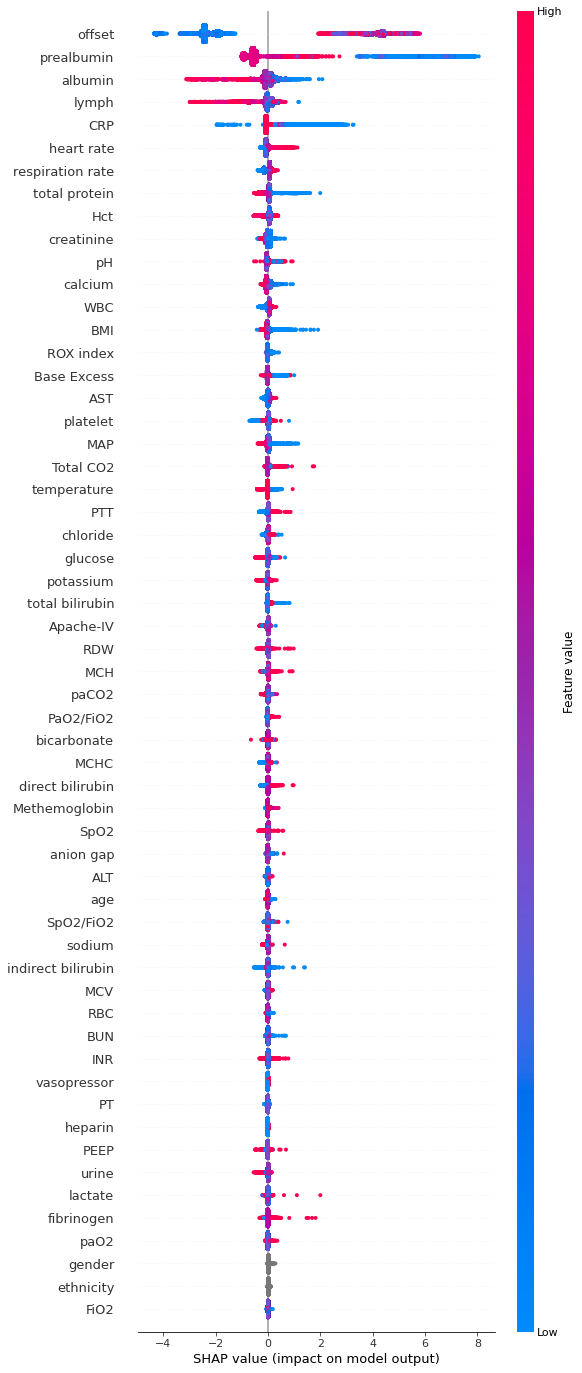

In [25]:
shap.plots.beeswarm(
    shap_values,
    max_display=99,
)


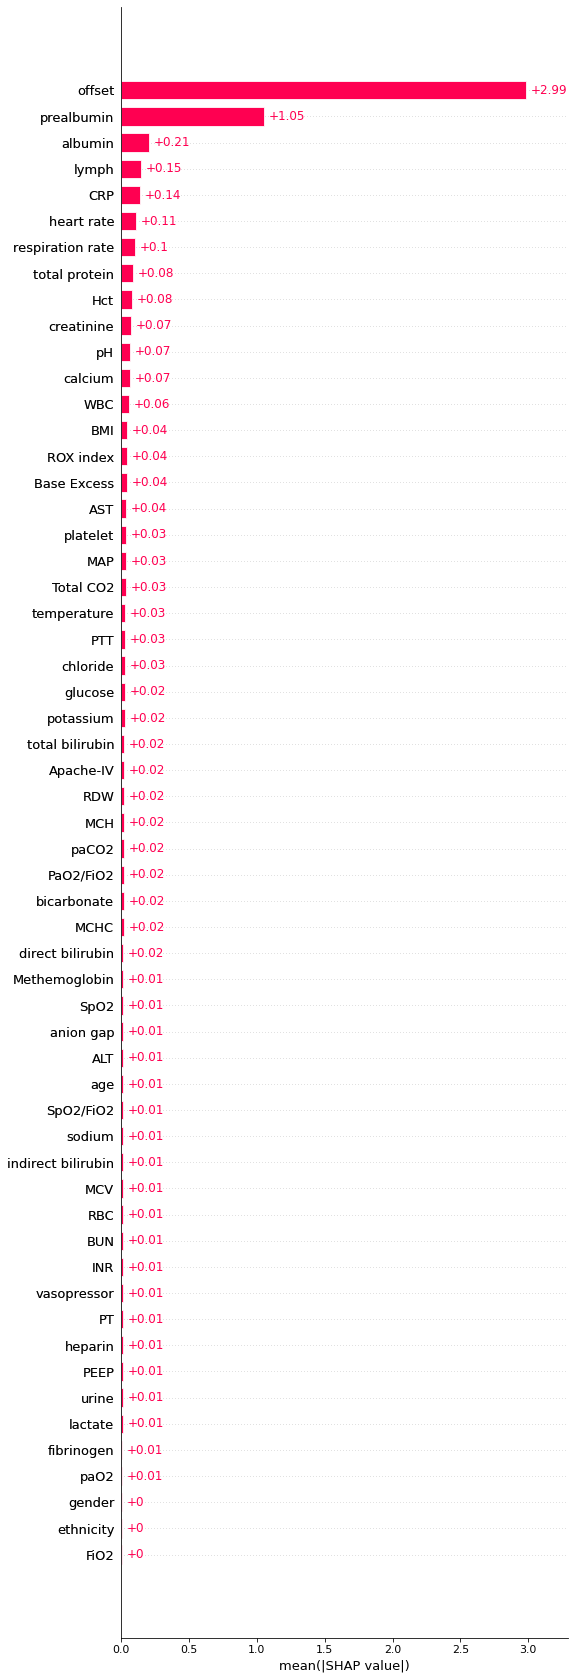

In [26]:
shap.plots.bar(
    shap_values,
    max_display=99,
)
